# Link prediction example: GraphSAGE on the Cora citation dataset

In [1]:
import networkx as nx
import pandas as pd
import os

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, link_classification

import keras 
from keras.models import load_model

from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar

Using TensorFlow backend.


In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [2]:
import numpy as np

In [209]:
import pickle

### Loading the CORA network data

In [205]:
DATA_DIR = os.getenv("DATA_DIR")
MODELS_DIR = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "models")
edgefile = os.path.join(DATA_DIR, "processed_network", "graphsage_test.csv.gz")

Load the graph from edgelist

In [40]:
edgelist = pd.read_csv(edgefile, compression="gzip", sep='\t')
edgelist["label"] = "go_to"  # set the edge type

In [41]:
edgelist.head()

,source,target,weight,label
0,/government/publications/guidance-for-dependan...,/visa-fees,24,go_to
1,/visa-fees,/find-a-visa-application-centre,433,go_to
2,/entering-staying-uk/family-visas,/uk-family-visa,148,go_to
3,/uk-family-visa,/uk-family-visa/partner-spouse,10863,go_to
4,/uk-family-visa/partner-spouse,/government/publications/application-for-uk-vi...,1037,go_to


In [42]:
node_id = {}
counter=0
for val in zip(edgelist.source.values, edgelist.target.values):
    for v in val:
        if v not in node_id.keys():
            node_id[v] = counter
            counter+=1

In [43]:
edgelist['source_id'] = edgelist.source.map(lambda x : int(node_id[x]))
edgelist['target_id'] = edgelist.target.map(lambda x : int(node_id[x]))

In [207]:
edgelist.head()

,source2,target2,weight,label,source,target
0,/government/publications/guidance-for-dependan...,/visa-fees,24,go_to,0,1
1,/visa-fees,/find-a-visa-application-centre,433,go_to,1,2
2,/entering-staying-uk/family-visas,/uk-family-visa,148,go_to,3,4
3,/uk-family-visa,/uk-family-visa/partner-spouse,10863,go_to,4,5
4,/uk-family-visa/partner-spouse,/government/publications/application-for-uk-vi...,1037,go_to,5,6


In [45]:
edgelist.columns

Index(['source', 'target', 'weight', 'label', 'source_id', 'target_id'], dtype='object')

In [46]:
edgelist.rename(columns={'source':'source2', 'target':'target2', 'source_id':'source', 'target_id':'target'},inplace=True)

Load the features and subject for the nodes

In [48]:
# cora_dir = "/Users/felisialoukou/Documents/graph-embeddings/data/cora"
# os.listdir(cora_dir)

In [49]:
# feature_names = ["w_{}".format(ii) for ii in range(1433)]
# column_names =  feature_names + ["subject"]
# node_data = pd.read_table(os.path.join(cora_dir, "cora.content"), header=None, names=column_names)

In [50]:
content_api = os.path.join(DATA_DIR, "content_api","07-02-19")
json = pd.read_csv(os.path.join(content_api,"content_json.csv.gz"), compression="gzip")

In [51]:
json[['url','title','description']].head()

,url,title,description
0,/government/publications/guidance-for-dependan...,Guidance for dependants of UK visa applicants ...,Full guidance on the policy for applications b...
1,/visa-fees,Visa fees,Check how much your visa application costs in ...
2,/find-a-visa-application-centre,Find a visa application centre,"Find the address, contact details and opening ..."
3,/entering-staying-uk/family-visas,Family visas,NaN
4,/uk-family-visa,"Family visas: apply, extend or switch","Get a family visa for the UK, live with your s..."


In [53]:
len(node_id)

138372

### Compute text features, tfidf

In [79]:
text_dict = {}
for tup in json.itertuples():
    if tup.url in node_id.keys():
        text_dict[node_id[tup.url]] = "{} {}".format(tup.title, tup.description).rstrip()

In [80]:
text_dict[0]

'Guidance for dependants of UK visa applicants (Tiers 1, 2, 4, 5) Full guidance on the policy for applications by the family of people who have UK visas under the points-based system (PBS dependants).'

In [78]:
len(text_dict)

121054

In [59]:
text_list = [(key,value) for key,value in text_dict.items()]
text = [(value) for key,value in text_list]
index = [key for key,value in text_list]

In [70]:
len(text_list)

121054

In [61]:
vectorizer = TfidfVectorizer(stop_words="english", max_features=1500)
X = vectorizer.fit_transform(text)

In [211]:
pickle.dump(vectorizer, open(os.path.join(MODELS_DIR, "vectorizer.pickle"), "wb"))

In [62]:
X.shape[0]

121054

### Initialize `node_data`

In [67]:
node_data = pd.DataFrame(X.todense(),index=index)

In [81]:
node_data.head()

,0,1,2,3,4,5,6,7,8,9,...,1490,1491,1492,1493,1494,1495,1496,1497,1498,1499
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Define a set of node features that will be used by the model as the difference between the set of all node features and a list of user-defined node attributes to ignore:

In [82]:
node_data.shape,len(node_id)

((121054, 1500), 138372)

In [83]:
# ignore_attr = []
# feature_names = sorted(set(column_names) - set(ignore_attr))
feature_names = node_data.columns
feature_names

RangeIndex(start=0, stop=1500, step=1)

We need to convert node features that will be used by the model to numeric values that are required for GraphSAGE input. Note that all node features in the Cora dataset, except the categorical "subject" feature, are already numeric, and don't require the conversion.

In [84]:
if "subject" in feature_names:
    # Convert node features to numeric vectors
    feature_encoding = feature_extraction.DictVectorizer(sparse=False)
    node_features = feature_encoding.fit_transform(
        node_data[feature_names].to_dict("records")
    )
else:  # node features are already numeric, no further conversion is needed
    node_features = node_data[feature_names].values

### Filter down the edgelist so it only contains nodes with text

In [87]:
filtered_edges = edgelist[(edgelist.source.isin(node_data.index))&(edgelist.target.isin(node_data.index))]

In [90]:
edgelist.shape

(454260, 6)

In [91]:
filtered_edges.shape

(432936, 6)

In [95]:
filtered_edges.head()

,source2,target2,weight,label,source,target
0,/government/publications/guidance-for-dependan...,/visa-fees,24,go_to,0,1
1,/visa-fees,/find-a-visa-application-centre,433,go_to,1,2
2,/entering-staying-uk/family-visas,/uk-family-visa,148,go_to,3,4
3,/uk-family-visa,/uk-family-visa/partner-spouse,10863,go_to,4,5
4,/uk-family-visa/partner-spouse,/government/publications/application-for-uk-vi...,1037,go_to,5,6


### Set up graph from edgelist

In [96]:
G = nx.from_pandas_edgelist(filtered_edges[['source','target','label']], edge_attr="label")

In [197]:
type(G)

networkx.classes.graph.Graph

Add node data to G:

In [100]:
for nid, f in zip(node_data.index, node_features):
    if nid in G.node.keys():
        G.node[nid][globalvar.TYPE_ATTR_NAME] = "page"  # specify node type
        G.node[nid]["feature"] = f

From the original graph G, extract a randomly sampled subset of test edges (true and false citation links) and the reduced graph G_test with the positive test edges removed:

In [101]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p=0.1, method="global"
#     , keep_connected=True
)

Removed 1000 edges
Removed 2000 edges
Removed 3000 edges
Removed 4000 edges
Removed 5000 edges
Removed 6000 edges
Removed 7000 edges
Removed 8000 edges
Removed 9000 edges
Removed 10000 edges
Removed 11000 edges
Removed 12000 edges
Removed 13000 edges
Removed 14000 edges
Removed 15000 edges
Removed 16000 edges
Removed 17000 edges
Removed 18000 edges
Sampled 1000 negative examples
Sampled 2000 negative examples
Sampled 3000 negative examples
Sampled 4000 negative examples
Sampled 5000 negative examples
Sampled 6000 negative examples
Sampled 7000 negative examples
Sampled 8000 negative examples
Sampled 9000 negative examples
Sampled 10000 negative examples
Sampled 11000 negative examples
Sampled 12000 negative examples
Sampled 13000 negative examples
Sampled 14000 negative examples
Sampled 15000 negative examples
Sampled 16000 negative examples
Sampled 17000 negative examples
Sampled 18000 negative examples
** Sampled 18053 positive and 18053 negative edges. **


The reduced graph G_test, together with the test ground truth set of links (edge_ids_test, edge_labels_test), will be used for testing the model.

Now repeat this procedure to obtain the training data for the model. From the reduced graph G_test, extract a randomly sampled subset of train edges (true and false citation links) and the reduced graph G_train with the positive train edges removed:

In [102]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p=0.1, method="global"
#     , keep_connected=True
)

Removed 1000 edges
Removed 2000 edges
Removed 3000 edges
Removed 4000 edges
Removed 5000 edges
Removed 6000 edges
Removed 7000 edges
Removed 8000 edges
Removed 9000 edges
Removed 10000 edges
Removed 11000 edges
Removed 12000 edges
Removed 13000 edges
Removed 14000 edges
Removed 15000 edges
Removed 16000 edges
Sampled 1000 negative examples
Sampled 2000 negative examples
Sampled 3000 negative examples
Sampled 4000 negative examples
Sampled 5000 negative examples
Sampled 6000 negative examples
Sampled 7000 negative examples
Sampled 8000 negative examples
Sampled 9000 negative examples
Sampled 10000 negative examples
Sampled 11000 negative examples
Sampled 12000 negative examples
Sampled 13000 negative examples
Sampled 14000 negative examples
Sampled 15000 negative examples
Sampled 16000 negative examples
** Sampled 16248 positive and 16248 negative edges. **


G_train, together with the train ground truth set of links (edge_ids_train, edge_labels_train), will be used for training the model.

Convert G_train and G_test to StellarGraph objects (undirected, as required by GraphSAGE) for ML:

In [103]:
G_train = sg.StellarGraph(G_train, node_features="feature")
G_test = sg.StellarGraph(G_test, node_features="feature")

In [104]:
# len(list(G_train.nodes))

120990

In [105]:
# list(G_train.nodes)[0:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [106]:
# G_train.nodes[35]['feature'].shape

Summary of G_train and G_test - note that they have the same set of nodes, only differing in their edge sets:

In [107]:
print(G_train.info())

StellarGraph: Undirected multigraph
 Nodes: 120990, Edges: 267205

 Node types:
  page: [120990]
        Attributes: {'feature'}
    Edge types: page-go_to->page

 Edge types:
    page-go_to->page: [267205]



In [108]:
print(G_test.info())

StellarGraph: Undirected multigraph
 Nodes: 120990, Edges: 283453

 Node types:
  page: [120990]
        Attributes: {'feature'}
    Edge types: page-go_to->page

 Edge types:
    page-go_to->page: [283453]



Next, we create the link mappers for sampling and streaming training and testing data to the model. The link mappers essentially "map" pairs of nodes `(paper1, paper2)` to the input of GraphSAGE: they take minibatches of node pairs, sample 2-hop subgraphs with `(paper1, paper2)` head nodes extracted from those pairs, and feed them, together with the corresponding binary labels indicating whether those pairs represent true or false citation links, to the input layer of the GraphSAGE model, for SGD updates of the model parameters.

Specify the minibatch size (number of node pairs per minibatch) and the number of epochs for training the model:

### Model parameters

In [109]:
batch_size = 25
epochs = 20

Specify the sizes of 1- and 2-hop neighbour samples for GraphSAGE:

Note that the length of `num_samples` list defines the number of layers/iterations in the GraphSAGE model. In this example, we are defining a 2-layer GraphSAGE model.

In [110]:
num_samples = [20, 10]

### Set up train and test set data generators

In [111]:
train_gen = GraphSAGELinkGenerator(G_train, batch_size, num_samples).flow(edge_ids_train,edge_labels_train)
test_gen = GraphSAGELinkGenerator(G_test,  batch_size, num_samples).flow(edge_ids_test, edge_labels_test)

Build the model: a 2-layer GraphSAGE model acting as node representation learner, with a link classification layer on concatenated `(paper1, paper2)` node embeddings.

GraphSAGE part of the model, with hidden layer sizes of 50 for both GraphSAGE layers, a bias term, and no dropout. (Dropout can be switched on by specifying a positive dropout rate, 0 < dropout < 1)
Note that the length of layer_sizes list must be equal to the length of num_samples, as len(num_samples) defines the number of hops (layers) in the GraphSAGE model.

In [112]:
layer_sizes = [20, 20]
assert len(layer_sizes) == len(num_samples)

graphsage = GraphSAGE(
        layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.3
    )

In [113]:
# Expose input and output sockets of graphsage, for source and destination nodes:
x_inp_src, x_out_src = graphsage.default_model(flatten_output=False)
x_inp_dst, x_out_dst = graphsage.default_model(flatten_output=False)
# re-pack into a list where (source, destination) inputs alternate, for link inputs:
x_inp = [x for ab in zip(x_inp_src, x_inp_dst) for x in ab]
# same for outputs:
x_out = [x_out_src, x_out_dst]

Final link classification layer that takes a pair of node embeddings produced by graphsage, applies a binary operator to them to produce the corresponding link embedding ('ip' for inner product; other options for the binary operator can be seen by running a cell with `?link_classification` in it), and passes it through a dense layer:

### Set up `link_classification` layer and model

In [114]:
prediction = link_classification(
        output_dim=1, output_act="sigmoid", edge_feature_method='ip'
    )(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


Stack the GraphSAGE and prediction layers into a Keras model, and specify the loss

In [115]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
        optimizer=keras.optimizers.Adam(lr=1e-3),
        loss=keras.losses.binary_crossentropy,
        metrics=[keras.metrics.binary_accuracy],
    )

Evaluate the initial (untrained) model on the train and test set:

In [116]:
init_train_metrics = model.evaluate_generator(train_gen)
init_test_metrics = model.evaluate_generator(test_gen)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Train Set Metrics of the initial (untrained) model:
	loss: 0.6491
	binary_accuracy: 0.7373

Test Set Metrics of the initial (untrained) model:
	loss: 0.6290
	binary_accuracy: 0.7360


In [200]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 20, 1500)     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 200, 1500)    0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 20, 1500)     0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 200, 1500)    0                                            
__________________________________________________________________________________________________
input_1 (I

### Train the model

In [117]:
history = model.fit_generator(
        train_gen,
        epochs=epochs,
        validation_data=test_gen,
        verbose=2,
        shuffle=True,
    )

Epoch 1/20
 - 340s - loss: 0.3057 - binary_accuracy: 0.8716 - val_loss: 0.3197 - val_binary_accuracy: 0.8901
Epoch 2/20
 - 334s - loss: 0.2102 - binary_accuracy: 0.9194 - val_loss: 0.3074 - val_binary_accuracy: 0.9139
Epoch 3/20
 - 318s - loss: 0.1728 - binary_accuracy: 0.9359 - val_loss: 0.2969 - val_binary_accuracy: 0.9155
Epoch 4/20
 - 327s - loss: 0.1540 - binary_accuracy: 0.9421 - val_loss: 0.3022 - val_binary_accuracy: 0.9181
Epoch 5/20
 - 321s - loss: 0.1425 - binary_accuracy: 0.9471 - val_loss: 0.2920 - val_binary_accuracy: 0.9209
Epoch 6/20
 - 320s - loss: 0.1362 - binary_accuracy: 0.9530 - val_loss: 0.2808 - val_binary_accuracy: 0.9219
Epoch 7/20
 - 319s - loss: 0.1250 - binary_accuracy: 0.9533 - val_loss: 0.2913 - val_binary_accuracy: 0.9211
Epoch 8/20
 - 324s - loss: 0.1182 - binary_accuracy: 0.9536 - val_loss: 0.2870 - val_binary_accuracy: 0.9197
Epoch 9/20
 - 321s - loss: 0.1150 - binary_accuracy: 0.9579 - val_loss: 0.2810 - val_binary_accuracy: 0.9205
Epoch 10/20
 - 320s

Plot the training history:

### Plot metrics

In [118]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    metrics = sorted(history.history.keys())
    metrics = metrics[:len(metrics)//2]
    
    f,axs = plt.subplots(1, len(metrics), figsize=(12,4))

    for m,ax in zip(metrics,axs):
        # summarize history for metric m
        ax.plot(history.history[m])
        ax.plot(history.history['val_' + m])
        ax.set_title(m)
        ax.set_ylabel(m)
        ax.set_xlabel('epoch')
        ax.legend(['train', 'test'], loc='upper right')

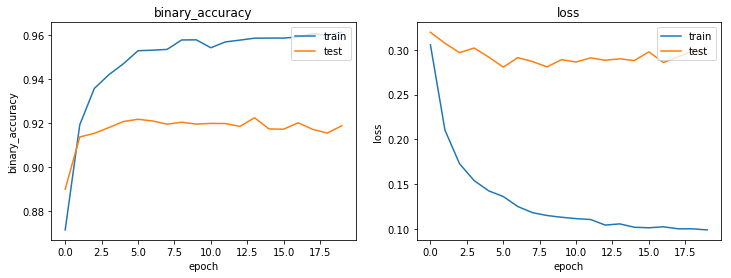

In [119]:
plot_history(history)

Evaluate the trained model on test citation links:

In [120]:
train_metrics = model.evaluate_generator(train_gen)
test_metrics = model.evaluate_generator(test_gen)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Train Set Metrics of the trained model:
	loss: 0.2044
	binary_accuracy: 0.9621

Test Set Metrics of the trained model:
	loss: 0.2995
	binary_accuracy: 0.9194


### Predict on `test_gen` link_mapper

In [121]:
type(test_gen)

stellargraph.mapper.link_mappers.LinkSequence

In [135]:
train_gen.type_adjacency_list

[('page', [2]),
 ('page', [3]),
 ('page', [4]),
 ('page', [5]),
 ('page', []),
 ('page', [])]

In [136]:
pred = model.predict_generator(test_gen)

In [212]:
len(test_gen.ids)

36106

In [137]:
pred[0:10]

array([[0.99702704],
       [0.99129677],
       [0.98810685],
       [0.83475816],
       [0.99734855],
       [0.9958212 ],
       [0.9960351 ],
       [0.9460257 ],
       [0.46158177],
       [0.9307431 ]], dtype=float32)

In [206]:
model.save(os.path.join(MODELS_DIR,'graphsage.h5'))

### Write `content_ids` to file for future feature representations

In [147]:
json[json.url == "/government/publications/guidance-for-dependants-of-uk-visa-applicants-tiers-1-2-4-5"].url

0    /government/publications/guidance-for-dependan...
Name: url, dtype: object

In [154]:
id_node = {}
for key,value in node_id.items():
    id_node[value] = key

In [156]:
json.shape, json.url.nunique()

((121054, 13), 121054)

In [160]:
url_id = dict(zip(json.url,json.content_id))

In [180]:
content_ids = []
for ind, i in enumerate(index):
    url_i = id_node[i]
    content_id = url_id[url_i]
    if ind%20000==0:
        print(ind)
    if content_id is np.nan:
        print(url_i)
    else:
        content_ids.append(content_id)

0
/government/publications/prepare-to-drive-in-the-eu-after-brexit
/government/statistics/announcements/rough-sleeping-in-england-autumn-2018
/government/statistics/announcements/english-housing-survey-2017-to-2018-headline-report
/government/statistics/announcements/economic-review-january-2019
/government/publications/eu-settlement-scheme-assisted-digital-service/assisted-digital-locations--3
/tax-disc
/government/publications/prepare-to-drive-in-the-eu-after-brexit?fbclid=iwar3nfg-xwip54yeluquu0awmkdfjqcyvww9mhdi36wz1lpkdyox5wqnynnw
/government/publications/cac-outcome-nuj-bbc-news/application-progress
/guidance/the-uks-exit-from-the-eu-important-information-for-uk-nationals
20000
/guidance/national-planning-policy-framework/13-facilitating-the-sustainable-use-of-minerals
/guidance/status-of-eu-nationals-in-the-uk-what-you-need-to-know.ro
/apply-uk-visa
/guidance/requests-for-personal-data-and-service-records
/contact-ukvi-outside-uk
40000
/government/collections/dwp-detailed-benefi

In [181]:
unique_content_ids = set(content_ids)
len(unique_content_ids)

48594

In [199]:
np.nan in unique_content_ids

False

In [183]:
with open(os.path.join(DATA_DIR,"content_ids.csv"),"w") as writer:
    writer.write("content_id\n")
    for cid in unique_content_ids:
        writer.write("{}\n".format(cid))

In [198]:
for item in test_gen[0][1]:
    print(len(item))

TypeError: object of type 'numpy.int64' has no len()